# Improving Robustness Against Evasion Attacks with _Adversarial Training_ (`Computer Vision`)

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

**_Adversarial machine learning_ is the study of the attacks on [machine learning](https://en.wikipedia.org/wiki/Machine_learning "Machine learning") algorithms and the defenses against such attacks. Recent surveys expose the fact that practitioners report a dire need for better protecting machine learning systems in real-world applications.**

**One of the alternatives for making models more resilient against adversarial attacks is _adversarial training_. In adversarial training, we generate adversarial examples and use them as samples (with their correct labels) for training (retraining) the original model, making it more robust.**

**In this notebook we will create an adversarial dataset to train and test the robustness of two different models. You can learn more about evasion attacks (a.k.a. _adversarial examples_) in both of [these](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/bbe9c0a77499fa68de7c6d53bf5ef7e0b43a25e0/ML%20Adversarial/evasion_attacks.ipynb) [notebooks](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/bbe9c0a77499fa68de7c6d53bf5ef7e0b43a25e0/ML%20Adversarial/evasion_attacks_FGSM.ipynb).** 

![image](<https://cdn.vox-cdn.com/thumbor/uXLBjJlvk7QNC_HfXbkThG3sHPs=/0x0:652x316/1200x800/filters:focal(274x106:378x210):no_upscale()/cdn.vox-cdn.com/uploads/chorus_image/image/58191589/adversarial_patch_.0.gif>)

**The technique used in this notebook is the _Fast Gradient Sign Method_ ([FGSM](https://arxiv.org/abs/1412.6572)), proposed by _[Ian J. Goodfellow](https://arxiv.org/search/stat?searchtype=author&query=Goodfellow%2C+I+J), [Jonathon Shlens](https://arxiv.org/search/stat?searchtype=author&query=Shlens%2C+J), [Christian Szegedy](https://arxiv.org/search/stat?searchtype=author&query=Szegedy%2C+C)_.**

In [1]:
import keras
import numpy as np
import tensorflow as tf
from matplotlib import cm
import matplotlib.pyplot as plt
from keras.utils import np_utils
from keras.datasets import cifar10
from keras import datasets, models
from keras.models import Sequential
from keras.preprocessing import image

**In this notebook, we will be attacking a CNN trained on the *CIFAR-10 dataset*. The CIFAR-10 dataset ([Canadian Institute For Advanced Research](https://en.wikipedia.org/wiki/Canadian_Institute_for_Advanced_Research "Canadian Institute for Advanced Research")) is a collection of images that are commonly used to train [machine learning](https://en.wikipedia.org/wiki/Machine_learning "Machine learning") and [computer vision](https://en.wikipedia.org/wiki/Computer_vision "Computer vision") algorithms. It is one of the most widely used datasets for machine learning research, containing 60,000 32x32 color images in 10 different classes. The ten classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks (there are 6,000 images of each class).**

**This model is the same one we trained in [this notebook](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/bbe9c0a77499fa68de7c6d53bf5ef7e0b43a25e0/ML%20Explainability/CV%20Interpreter/CNN_model_maker.ipynb).**

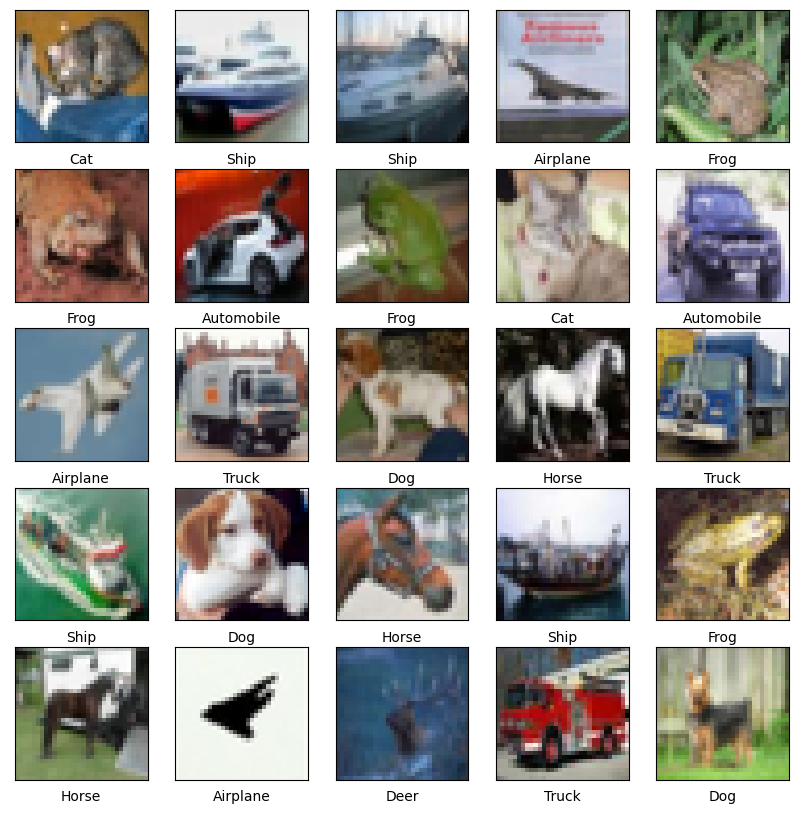

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

In [3]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

X = np.concatenate((x_train,x_test),axis = 0)
X = X.astype('float32')
X = X / 255.
Y = np.concatenate((y_train,y_test),axis = 0)
Y = np_utils.to_categorical(Y, 10)

class_names = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer',
               'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_test[i][0]])

plt.show()

model = tf.keras.models.load_model('models\pre_trained_Cifar_CNN.h5')
x_test = x_test.astype('float32')
x_test = x_test / 255.
y_test = np_utils.to_categorical(y_test, 10)
test_loss_score, test_acc_score = model.evaluate(x_test, y_test, verbose=0)
model.summary()
print(f'Loss: {round(test_loss_score, 2)}.')
print(f'Accuracy: {round(test_acc_score * 100, 2)} %.')

**Now let's write a function to return labels, predictions and images (feel free to write a better one).** 🙃

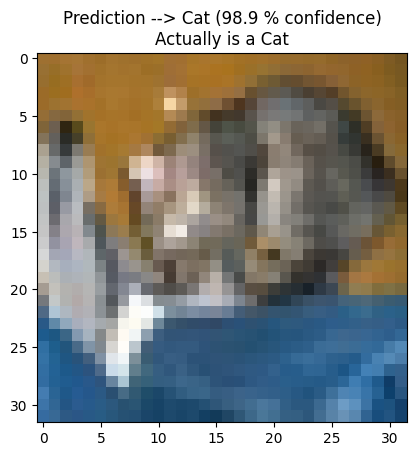

In [3]:
sample = 0 # 0, 9999

img_tensor = np.expand_dims(x_test[sample], axis=0)
pred = [round(num, 3) for num in list(model.predict(img_tensor, verbose=0)[0])]

plt.figure()
plt.imshow(x_test[sample])
plt.title(
    f'Prediction --> {class_names[np.array(pred).argmax()]} ({round(max(pred) * 100, 2)} % confidence)\nActually is a {class_names[y_test[sample].argmax()]}')
plt.show()

**Now that we have chosen a sample, we will use the `tf.keras.losses.CategoricalCrossentropy` class to create a loss function. We will also record the class index of this specific sample.**

**We will use this loss function (_rather than serving as a supervision signal for updating the parameters of a neural network_), in combination with the class `tf.GradientTape()` to create an image (perturbation) that generates the largest possible loss (here we are moving the gradient in the direction in which the loss increases, i.e., gradient ascent) concerning a specific class.** 

**And that is what the _Fast Sign Gradient Method_ is all about. In essence, `FGSM` is to add the noise (not random noise) whose direction is the same as the gradient of the cost function with respect to the data.**

**All this will be encapsulated by a function called `create_adversarial_pattern`.**

1/1 [==============================] - 0s 22ms/step


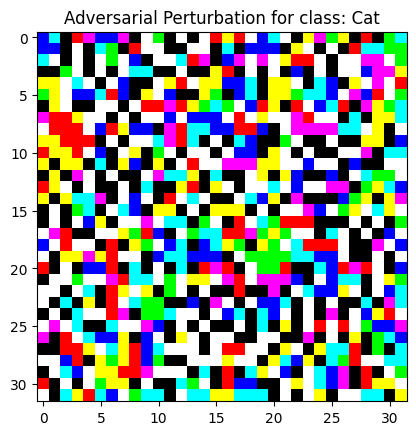

In [140]:
img_tensor = np.expand_dims(x_test[sample], axis=0)
image_probs = model.predict(img_tensor)
class_index = np.argmax(image_probs[0])

loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = model(input_image)
        loss = loss_object(input_label, prediction)
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

label = tf.one_hot(class_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(
    tf.convert_to_tensor(img_tensor, dtype=tf.float32), label)
adversarial_perturbation = (perturbations[0] * 0.5 + 0.5).numpy()
plt.figure()
plt.imshow(adversarial_perturbation)
plt.title(f'Adversarial Perturbation for class: {class_names[class_index]}')
plt.show()

**Now, we combine our `perturbation` with the `original image` to generate a misclassification. For this explanation, we will only use an  $\epsilon$ of $0.01$, since we are interested in generating attacks that are "_imperceptible_" to the human observer. Since CIFAR 10 images are low resolution, even a small $\epsilon$ can be perceived by the careful eye.**

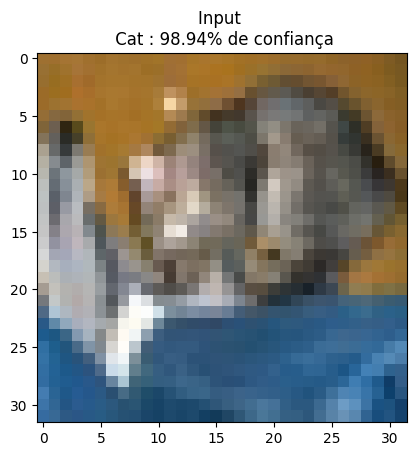

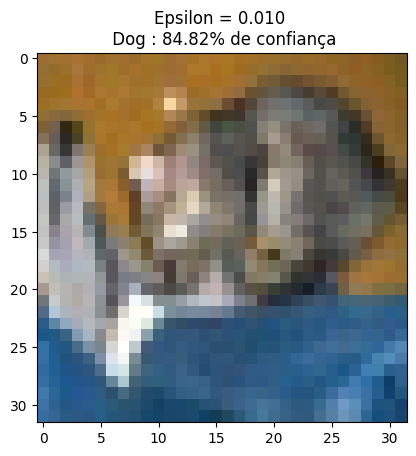

In [141]:
def display_images(img_tensor, description):
    image_probs = model.predict(
        tf.convert_to_tensor(img_tensor, dtype=tf.float32), verbose=0)
    class_confidence = image_probs.max()
    class_index = np.argmax(image_probs[0])
    plt.figure()
    plt.imshow(img_tensor[0])
    plt.title('{} \n {} : {}% de confiança'.format(description,
                                                   class_names[class_index], round(class_confidence * 100, 2)))
    plt.show()


epsilons = [0, 0.01]
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input')
                for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = img_tensor + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])

**As you can see, an $\epsilon$ of $0.01$ is enough to fool this model by a big margin.**

**In this notebook, we will use a very simple strategy for creating our adversarial dataset. We will simply convert ~40% of our original dataset (randomly picked) into adversarial examples, and then add those examples to the original dataset, thus creating an adversarial training dataset.**

**This can take considerable time, so if you wanted to skip this part and directly download the created dataset for this example, skip to the next cell.**

In [146]:
loss_object = tf.keras.losses.CategoricalCrossentropy()
eps = 0.01
adversarial_x = []
adversarial_y = []

for i in range(len(X)):

    # use ~40% of the dataset to create adversarial samples
    if np.random.uniform(0, 1) >= 0.6:

        # get info on the sample
        img_tensor = np.expand_dims(X[i], axis=0)
        image_probs = model.predict(img_tensor)
        class_index = np.argmax(image_probs[0])

        # target the especific label
        label = tf.one_hot(class_index, image_probs.shape[-1])
        label = tf.reshape(label, (1, image_probs.shape[-1]))

        # create perturbation
        perturbations = create_adversarial_pattern(
        tf.convert_to_tensor(img_tensor, dtype=tf.float32), label)
        adversarial_perturbation = (perturbations[0] * 0.5 + 0.5).numpy()

        # create adversrial sample
        adversarial_sample = tf.clip_by_value(img_tensor + eps*perturbations, -1, 1)

        # append to adversarial dataset
        adversarial_x.append(adversarial_sample[0].numpy())
        adversarial_y.append(Y[i])

adversarial_x = np.array(adversarial_x).astype('float32') 
adversarial_y = np.array(adversarial_y)

with open('adversarial_data_CIFAR_10.npy', 'wb') as f:
    np.save(f, adversarial_x)
    np.save(f, adversarial_y)

1/1 [==============================] - 0s 42ms/step


**[You can download the adversarial dataset here](https://drive.google.com/uc?export=download&id=1OrEZXsaA982wCoCRe4wqQk1A7DFi_am0).**

**We will divide our adversarial dataset into two parts. One to train a new model, and one to test the robustness of both models.**

In [4]:
with open('adversarial_data_CIFAR_10.npy', 'rb') as fp:
    adversarial_x = np.load(f)
    adversarial_y = np.load(f)
    fp.close()

adversarial_x_test = adversarial_x[:adversarial_x.shape[0] - 20000]
adversarial_x_training = adversarial_x[0:20000]

adversarial_y_test = adversarial_y[:adversarial_x.shape[0] - 20000]
adversarial_y_training = adversarial_y[0:20000]

X = np.concatenate((X,adversarial_x_training),axis = 0)
Y = np.concatenate((Y,adversarial_y_training),axis = 0)

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.15, random_state=42)

**We will now train the "same model" (_same architecture and hyperparemeters_) with this adversarial dataset. After training, if you compare the model performance (_accuracy_) with that of the model trained in the [original notebook](https://github.com/Nkluge-correa/teeny-tiny_castle/blob/bbe9c0a77499fa68de7c6d53bf5ef7e0b43a25e0/ML%20Explainability/CV%20Interpreter/CNN_model_maker.ipynb), you will see we outperform the original model by around ~2% in testing.**

In [4]:
 
from keras import layers

model = Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same',
          activation='relu', input_shape=(32, 32, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.5))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")
model.summary()
model.fit(x_train, y_train, validation_split=0.2, batch_size=128, epochs=80, verbose=1)
model.save('models\pre_trained_Cifar_CNN_with_adversarial_training.h5')

test_loss_score, test_acc_score = model.evaluate(x_test, y_test)

print(f'Final Loss: {round(test_loss_score, 2)}.')
print(f'Final Performance: {round(test_acc_score * 100, 2)} %.')

Version:  2.10.0
Eager mode:  True
GPU is available
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
    

**We will define the robustness score of our models as the accuracy against the separate adversarial dataset for tests.**

**With around 30% accuracy against the adversarial dataset, we also plot the confusion matrix below, where we can see the most common misclassifications generated by FGSM whit an $\epsilon$ of $0.01$.**

In [10]:
model = tf.keras.models.load_model('models\pre_trained_Cifar_CNN.h5')

print(f'\n# Model Evaluation Against Adversaries\n\n{"-" * 50}\n')
_, test_acc_score = model.evaluate(adversarial_x_test, adversarial_y_test, verbose=0)
print(f'- Robustness Score: {round(test_acc_score * 100, 2)} %.')

from sklearn.metrics import confusion_matrix

predictions = model.predict(adversarial_x_test, verbose=0)
matrix = confusion_matrix(adversarial_y_test.argmax(axis=1), predictions.argmax(axis=1))

import plotly.express as px
fig = px.imshow(matrix,
                labels=dict(x="Predicted", y="True label"),
                x=class_names,
                y=class_names,
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()



# Model Evaluation Against Adversaries

--------------------------------------------------

- Robustness Score: 30.55 %.


**However, the model trained with a combination of normal and perturbed data receives a robustness score of  around 94%!**

In [12]:
model = tf.keras.models.load_model('models\pre_trained_Cifar_CNN_with_adversarial_training.h5')

print(f'\nModel Evaluation Against Adversaries\n\n{"*" * 50}\n')
_, test_acc_score = model.evaluate(adversarial_x_test, adversarial_y_test, verbose=0)
print(f'Robustness Score: {round(test_acc_score * 100, 2)} %.')

from sklearn.metrics import confusion_matrix

predictions = model.predict(adversarial_x_test, verbose=0)
matrix = confusion_matrix(adversarial_y_test.argmax(axis=1), predictions.argmax(axis=1))

import plotly.express as px
fig = px.imshow(matrix,
                labels=dict(x="Predicted", y="True label"),
                x=class_names,
                y=class_names,
                text_auto=True
                )
fig.update_xaxes(side='top')
fig.update_layout(template='plotly_dark',
                  title='Confusion Matrix',
                  coloraxis_showscale=False,
                  paper_bgcolor='rgba(0, 0, 0, 0)',
                  plot_bgcolor='rgba(0, 0, 0, 0)')
fig.show()


Model Evaluation Against Adversaries

**************************************************

Robustness Score: 94.47 %.


**Adversarial training can help AI developers create more robust models against adversaries, even sometimes improving overall performance.** 🙃 

---

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).